# **Melodiff**

## **Basic usage**

### Setup

We start from Stable Diffusion pipeline. For that pipeline gpu configuration is needed.
First, please make sure you are using a GPU runtime to run this notebook, so inference is much faster. If the following command fails, use the `Runtime` menu above and select `Change runtime type`.

In [1]:
!nvidia-smi

Fri Mar  1 11:17:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Next, you should install `diffusers` as well `scipy`, `ftfy` and `transformers`. `accelerate` is used to achieve much faster loading.

In [2]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.9/524.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 12.7 MB/s eta 0:00:00


### Stable Diffusion Pipeline & Riffusion model

First, we load the pre-trained weights of all components of the model. We use Riffusion model (["riffusion/riffusion-model-v1](https://huggingface.co/riffusion/riffusion-model-v1)). This model is fine-tuning of Stable Diffusion model to produce Mel spectrogram images with a resolution of 512x512.

In [3]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("riffusion/riffusion-model-v1", torch_dtype=torch.float16).to("cuda")

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.84k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/284 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

We will use StableDiffusion Img2Img Pipeline to modify initial spectrogram. We produce new spectrogram, which will contain partial structure from the previous image (mainly we try to keep the melody) and new modifications based on new prompt. Following is a way, how to load the pipeline without expanding the RAM usage.

In [4]:
from diffusers import StableDiffusionImg2ImgPipeline

components = pipe.components

# weights are not reloaded into RAM
riffusion_img2img = StableDiffusionImg2ImgPipeline(**components)

Next we will define functions for tranfering from images to waveforms and from waveforms to images. We need different formats (audio or spectrogram) in various parts of our generating process. Following functions are mostly taken from Riffusion repository. We start with default definitions for parameters.

In [5]:
import numpy as np
from PIL import Image

image_width = 512
sample_rate = 44100  # [Hz]
clip_duration_ms = 5000  # [ms]

bins_per_image = 512
n_mels = 512

# FFT parameters
window_duration_ms = 100  # [ms]
padded_duration_ms = 400  # [ms]
step_size_ms = 10  # [ms]

# Derived parameters
num_samples = int(image_width / float(bins_per_image) * clip_duration_ms) * sample_rate
n_fft = int(padded_duration_ms / 1000.0 * sample_rate)
hop_length = int(step_size_ms / 1000.0 * sample_rate)
win_length = int(window_duration_ms / 1000.0 * sample_rate)

In [6]:
def spectrogram_from_image(
    image: Image.Image, max_volume: float = 50, power_for_image: float = 0.25
) -> np.ndarray:

    data = np.array(image).astype(np.float32)
    data = data[::-1, :, 0]
    data = 255 - data
    data = data * max_volume / 255
    data = np.power(data, 1 / power_for_image)

    return data

In [14]:
import torch
import torchaudio
from IPython.display import Audio

def waveform_from_spectrogram(
    Sxx: np.ndarray,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    num_samples=num_samples,
    sample_rate=sample_rate,
    mel_scale: bool = True,
    n_mels: int = 512,
    max_mel_iters: int = 200,
    num_griffin_lim_iters: int = 32,
    device: str = "cuda",
) -> np.ndarray:

    Sxx_torch = torch.from_numpy(Sxx).to(device)

    if mel_scale:
        mel_inv_scaler = torchaudio.transforms.InverseMelScale(
            n_mels=n_mels,
            sample_rate=sample_rate,
            f_min=0,
            f_max=10000,
            n_stft=n_fft // 2 + 1,
            norm=None,
            mel_scale="htk",
        ).to(device)

        Sxx_torch = mel_inv_scaler(Sxx_torch)

    griffin_lim = torchaudio.transforms.GriffinLim(
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        power=1.0,
        n_iter=num_griffin_lim_iters,
    ).to(device)

    waveform = griffin_lim(Sxx_torch).cpu().numpy()

    return waveform

In [8]:
def spectrogram_from_waveform(
    waveform: np.ndarray,
    sample_rate=sample_rate,
    n_fft=n_fft,
    hop_length=hop_length,
    win_length=win_length,
    mel_scale: bool = True,
    n_mels: int = 512,
) -> np.ndarray:

    spectrogram_func = torchaudio.transforms.Spectrogram(
        n_fft=n_fft,
        power=None,
        hop_length=hop_length,
        win_length=win_length,
    )

    waveform_tensor = torch.from_numpy(waveform.astype(np.float32)).reshape(1, -1)
    Sxx_complex = spectrogram_func(waveform_tensor).numpy()[0]

    Sxx_mag = np.abs(Sxx_complex)

    if mel_scale:
        mel_scaler = torchaudio.transforms.MelScale(
            n_mels=n_mels,
            sample_rate=sample_rate,
            f_min=0,
            f_max=10000,
            n_stft=n_fft // 2 + 1,
            norm=None,
            mel_scale="htk",
        )

        Sxx_mag = mel_scaler(torch.from_numpy(Sxx_mag)).numpy()

    return Sxx_mag

In [9]:
def image_from_spectrogram(spectrogram: np.ndarray, max_volume: float = 50, power_for_image: float = 0.25) -> Image.Image:

    data = np.power(spectrogram, power_for_image)
    data = data * 255 / max_volume
    data = 255 - data
    image = Image.fromarray(data.astype(np.uint8))
    image = image.transpose(Image.FLIP_TOP_BOTTOM)
    image = image.convert("RGB")

    return image

And we are ready to generate spectrogram images. We start with basic Riffusion spectrogram image generation as our base spectrogram image for audio.

In [10]:
prompt = "piano melodic pop"
generator = torch.Generator("cuda").manual_seed(1023)
specgram_img_1 = pipe(prompt,generator=generator).images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

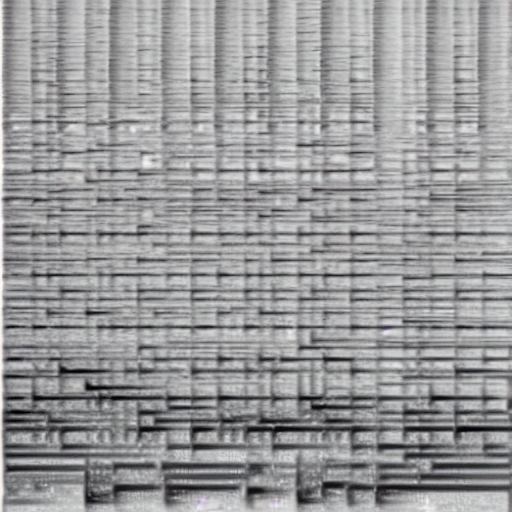

In [11]:
specgram_img_1

Now we use Img2img pipeline to modify previous image. **Important here is to choose correct strength. When strength is too low the spectrogram is too similar with original one and we do not receive new modification. When strength is too high, then spectrogram is too close to the new promopt, which may cause loss of melody and/or tempo from the base image. Good values of strength are usually about 0,4-0,5.**

  0%|          | 0/23 [00:00<?, ?it/s]

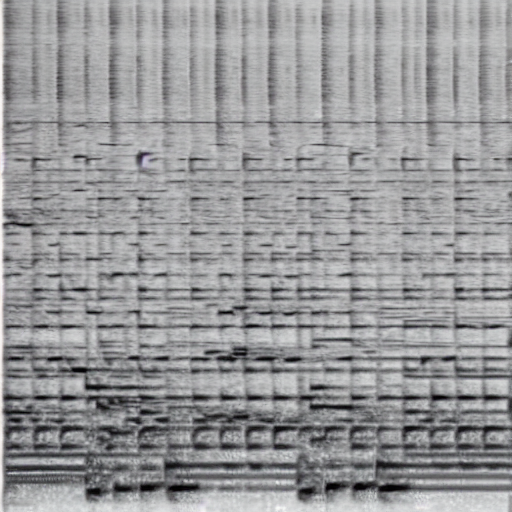

In [17]:
prompt = "flute"
generator = torch.Generator("cuda").manual_seed(1022)
specgram_mod_1 = riffusion_img2img(prompt=prompt, image=specgram_img_1, strength=0.47, generator=generator, guidance_scale=8.5).images[0]
specgram_mod_1

In [15]:
# Audio from base image
waveform_initial = waveform_from_spectrogram(spectrogram_from_image(specgram_img_1))
audio = Audio(waveform_initial, rate=sample_rate)
audio

In [18]:
# Modified audio by prompt
waveform_modified = waveform_from_spectrogram(spectrogram_from_image(specgram_mod_1))
audio_2 = Audio(waveform_modified, rate=sample_rate)
audio_2

As you can hear on previous audio files. First one is base with piano solo, second one plays the same melody on flute. I would say, it is cool. :)

## **Modify your own audio**

Usage is basically the same, just upload your audio at the beginning.

In [32]:
from google.colab import files

uploaded = files.upload()
audio_filename = list(uploaded.keys())[0]

print()
print(f"{audio_filename} successfully uploaded and saved as variable audio_filename.")

Saving Californiacation.wav to Californiacation.wav

Californiacation.wav successfully uploaded and saved as variable audio_filename.


In [33]:
import librosa

# upload and read your own wav file here (If you have your music in another audio format (mp3, midi,...), pleas use some online converter tool first).
audio_cust_whole, sample_rate = librosa.load(audio_filename, sr=44100)

In [22]:
# take just first 5 seconds of audio
audio_cust_data = audio_cust_whole[:225500]

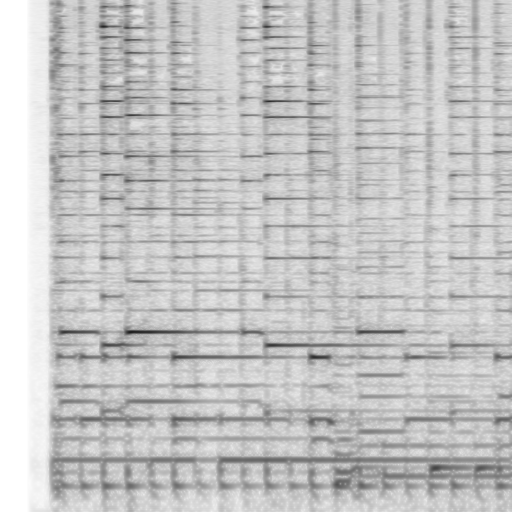

In [23]:
# Transfer audio to spectrogram image
spec_cust_data = spectrogram_from_waveform(audio_cust_data)


power_for_image = 0.25
max_volume = np.ceil(np.power(np.max(spec_cust_data),power_for_image)) # max volume depends on our audio recoding conditions
image_cust = image_from_spectrogram(spec_cust_data, max_volume=max_volume, power_for_image=power_for_image)
image_cust

  0%|          | 0/23 [00:00<?, ?it/s]

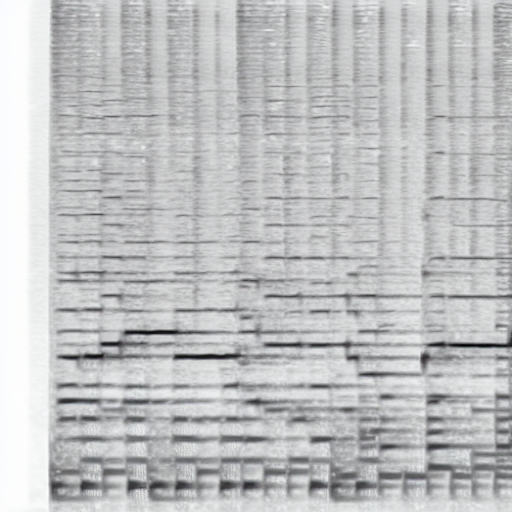

In [24]:
# Modify spectrogram
prompt = "flute and saxophone"
generator = torch.Generator("cuda").manual_seed(1022)
specgram_cust_1 = riffusion_img2img(prompt=prompt, image=image_cust, strength=0.47, generator=generator, guidance_scale=8.5).images[0]
specgram_cust_1

In [25]:
# Original audio
audio_cust = Audio(audio_cust_data, rate=sample_rate)
audio_cust

In [26]:
# Audio modified by prompt
waveform_cust_modified = waveform_from_spectrogram(spectrogram_from_image(specgram_cust_1))
audio_cust_mod = Audio(waveform_cust_modified, rate=sample_rate)
audio_cust_mod

## **Create longer audio modifications**

Again usage is very similar to basic usage. Just do the same thing twice (or as many times as you want). Each 5s audio sample is transfered to 512x512 image. Then it is modified by img2img pipeline. If you choose the same prompt, the same seed and the same strength, there is some consistency between modified samples. Transfer modified images back to audio and concatenate them. Usually you can hear slight sound of snap between samples.

You can use overlaps of audio samples and some averaging on that overlaps to mitigate the snap sound. (Overlap modification is not included in this notebook.)

In [27]:
# take next 5 seconds of audio
audio_cust_data_next = audio_cust_whole[225500:451000]

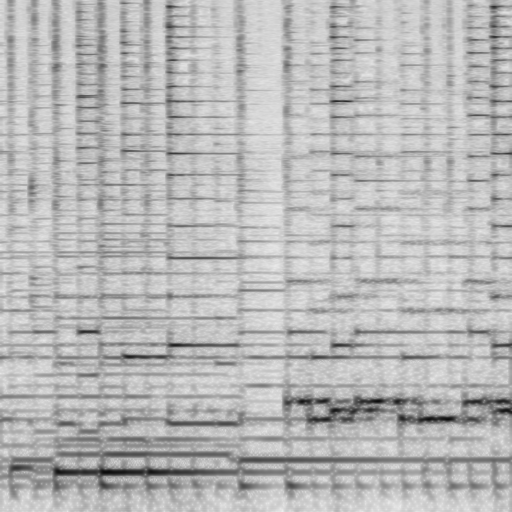

In [28]:
# Transfer audio to spectrogram image
spec_cust_data_next = spectrogram_from_waveform(audio_cust_data_next)

power_for_image = 0.25
max_volume_next = np.ceil(np.power(np.max(spec_cust_data_next),power_for_image))
image_cust_next = image_from_spectrogram(spec_cust_data_next, max_volume=max_volume_next, power_for_image=power_for_image)
image_cust_next

  0%|          | 0/23 [00:00<?, ?it/s]

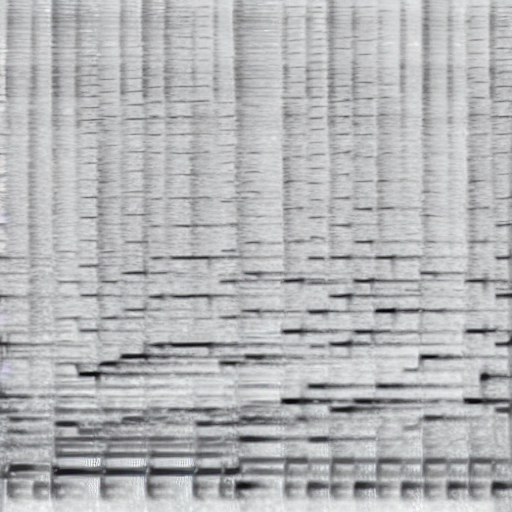

In [29]:
# Modify next spectrogram with the same promtp, seed, strength
prompt = "flute and saxophone"
generator = torch.Generator("cuda").manual_seed(1022)
specgram_cust_2 = riffusion_img2img(prompt=prompt, image=image_cust_next, strength=0.47, generator=generator, guidance_scale=8.5).images[0]
specgram_cust_2

In [30]:
# Original longer audio
audio_whole = Audio(audio_cust_whole[:451000], rate=sample_rate)
audio_whole

In [31]:
# Second audio modified by prompt
waveform_cust_modified_2 = waveform_from_spectrogram(spectrogram_from_image(specgram_cust_2))

# Concatenate waveforms and produce audio
waveform_cust_modified_whole = np.concatenate((waveform_cust_modified, waveform_cust_modified_2))
audio_cust_mod_whole = Audio(waveform_cust_modified_whole, rate=sample_rate)
audio_cust_mod_whole